# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

## 라이브러리 불러오기

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
<ipython-input-2-08a65c69185e>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [3]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


In [5]:
samsung_df.isna().sum()

price    0
dtype: int64

## 정상성 검정

정상성 조건
1. 모든 시점에 대해 일정한 평균을 가진다.
2. 모든 시점에 대해 일정한 분산을 가진다.
3. 공분산도 단지 시차에만 의존, 실제 특성 시점에는 의존하지 않는다.

<function matplotlib.pyplot.show(close=None, block=None)>

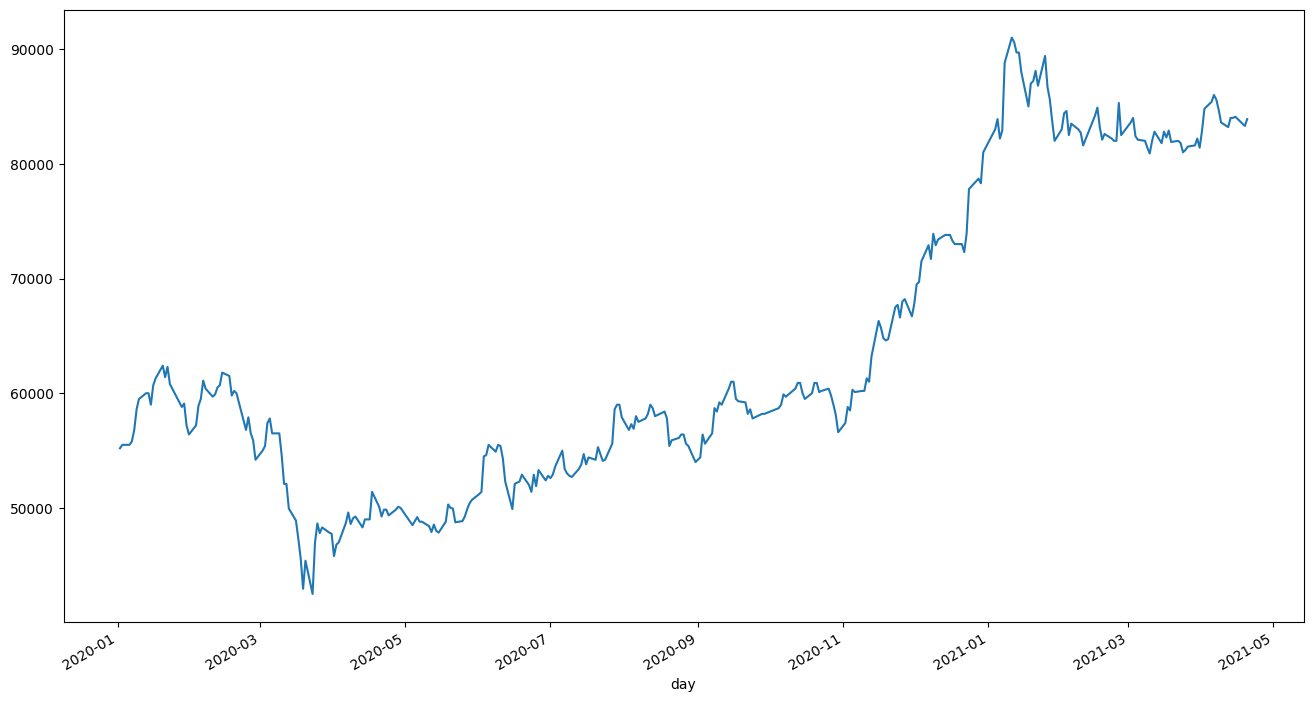

In [6]:
# 주가 시각화
plt.figure(figsize=(16,9))
samsung_df.price.plot(kind='line')
plt.show

### ADF, KPSS 검정

In [7]:
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test(samsung_df)

ADF Statistic: -0.21218947966329235
p-value: 0.9370529809409828
Critical Values: {'1%': -3.450886958636161, '5%': -2.870586350823483, '10%': -2.5715897843576827}


ADF 검정을 통해 검정통계량은 -0.212이며, p-value가 0.937로 매우 높게 나타남을 확인. 즉, 유의수준 0.05하에'시계열이 정상성이 아니다'라는 귀무가설을 채택함. 현재 주가 데이터는 비정상적인 시계열임.





In [8]:
def kpss_test(timeseries):
    result = kpss(timeseries)
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[3])

kpss_test(samsung_df)

KPSS Statistic: 2.145211628190742
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-8-5e0d7cc5c3fb>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries)


KPSS 검정을 통해 검정통계량은 2.15이며, p-value가 0.01로 유의수준 0.05하에 '시계열이 정상성이다'라는 귀무가설을 기각함. 즉, 현재 주가 데이터는 비정상적인 시계열이라는 동일한 결론이 나옴.

### ACF, PACF 시각화

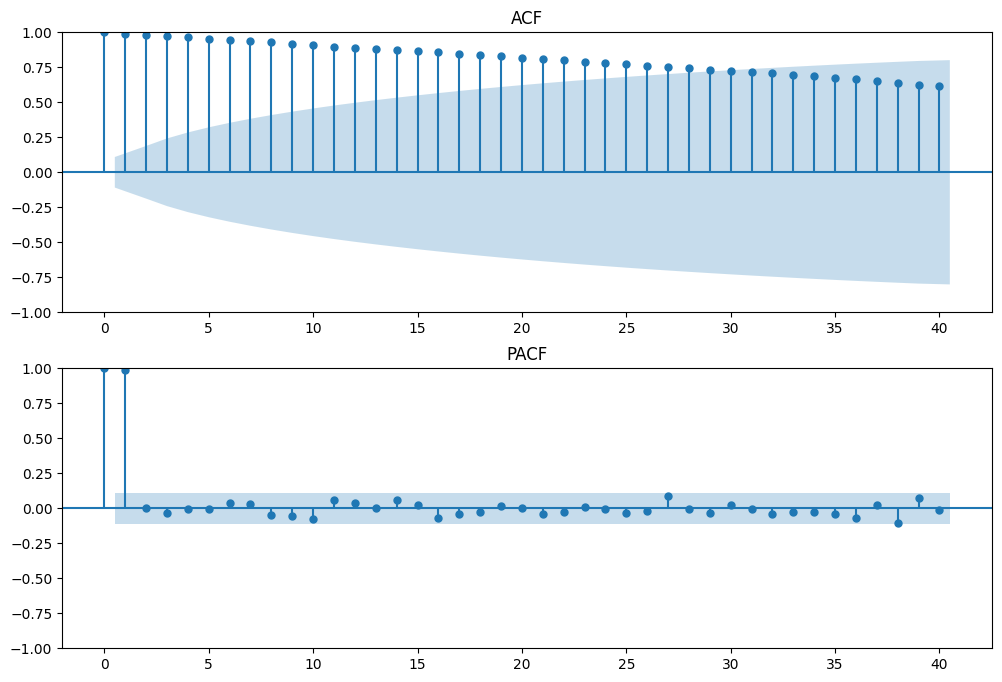

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(samsung_df['price'], ax=ax[0], lags = 40, alpha = 0.05)
ax[0].set_title('ACF')

plot_pacf(samsung_df['price'], ax=ax[1], lags=40, alpha=0.05)
ax[1].set_title('PACF')

plt.show()

ACF가 매우 천천히 감소하고, PACF에서는 절단점이 3인 것을 확인

### auto_arima를 사용한 모수 찾기

In [12]:
model = auto_arima(samsung_df['price'], seasonal=False, stepwise=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  322
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2737.755
Date:                Tue, 27 Feb 2024   AIC                           5477.510
Time:                        13:30:20   BIC                           5481.281
Sample:                             0   HQIC                          5479.016
                                - 322                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.494e+06   8.32e+04     17.947      0.000    1.33e+06    1.66e+06
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                61.49
Prob(Q):                              0.82   Pr

auto_arima를 통해 주가 데이터의 적절한 ARIMA 모형은 SARIMAX(0, 1, 0) 인 것을 확인.

### 최적의 모수 서치

In [14]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
p = range(0, 3)
d = range(0, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(samsung_df['price'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA{i} AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA(0, 0, 0) AIC : 8551.86
ARIMA(0, 0, 1) AIC : 6612.04


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2) AIC : 6306.24
ARIMA(0, 1, 0) AIC : 5477.51
ARIMA(0, 1, 1) AIC : 5479.38
ARIMA(0, 1, 2) AIC : 5481.31
ARIMA(0, 2, 0) AIC : 5677.35
ARIMA(0, 2, 1) AIC : 5625.83
ARIMA(0, 2, 2) AIC : 5601.4
ARIMA(1, 0, 0) AIC : 5502.98
ARIMA(1, 0, 1) AIC : 5504.87
ARIMA(1, 0, 2) AIC : 5506.53
ARIMA(1, 1, 0) AIC : 5479.36
ARIMA(1, 1, 1) AIC : 5479.97
ARIMA(1, 1, 2) AIC : 5483.32
ARIMA(1, 2, 0) AIC : 5646.49
ARIMA(1, 2, 1) AIC : 5595.6
ARIMA(1, 2, 2) AIC : 5597.48
ARIMA(2, 0, 0) AIC : 5504.85
ARIMA(2, 0, 1) AIC : 5505.32
ARIMA(2, 0, 2) AIC : 5508.62
ARIMA(2, 1, 0) AIC : 5481.27
ARIMA(2, 1, 1) AIC : 5483.28
ARIMA(2, 1, 2) AIC : 5483.97
ARIMA(2, 2, 0) AIC : 5632.34
ARIMA(2, 2, 1) AIC : 5599.83
ARIMA(2, 2, 2) AIC : 5605.63


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC 값이 가장 작은 ARIMA(0,1,0) model을 채택

In [15]:
model = ARIMA(samsung_df, order=(0, 1, 0))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  322
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2737.755
Date:                Tue, 27 Feb 2024   AIC                           5477.510
Time:                        13:33:11   BIC                           5481.281
Sample:                             0   HQIC                          5479.016
                                - 322                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.494e+06   8.32e+04     17.947      0.000    1.33e+06    1.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                61.49
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.54
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

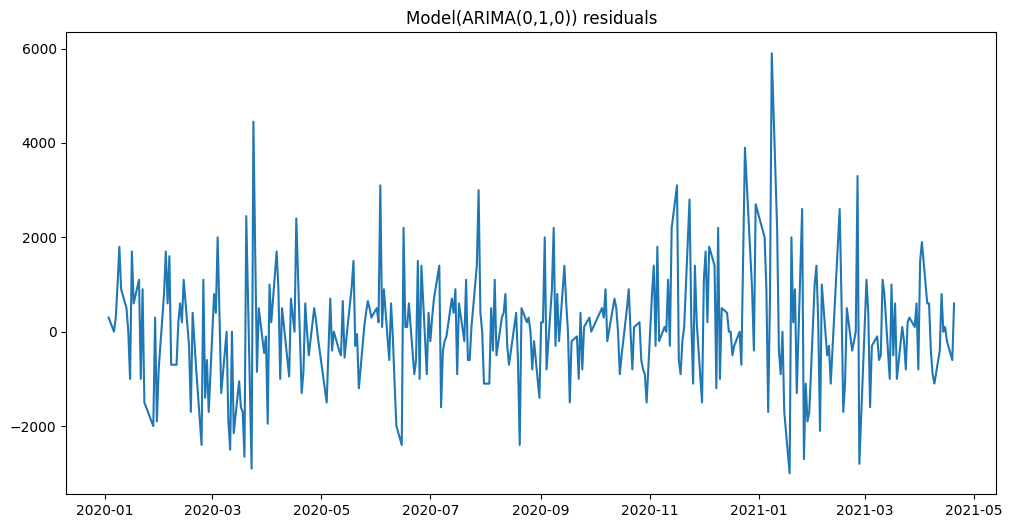

In [16]:
residuals = model_fit.resid[1:]
plt.figure(figsize=(12, 6))
plt.plot(samsung_df.index[1:], residuals)
plt.title('Model(ARIMA(0,1,0)) residuals')
plt.show()

잔차에 경향성이 없음을 확인

### 예측 결과

In [17]:
pred = model_fit.predict()
pred

day
2020-01-02        0.0
2020-01-03    55200.0
2020-01-06    55500.0
2020-01-07    55500.0
2020-01-08    55800.0
               ...   
2021-04-14    84000.0
2021-04-15    84000.0
2021-04-16    84100.0
2021-04-19    83900.0
2021-04-20    83300.0
Name: predicted_mean, Length: 322, dtype: float64

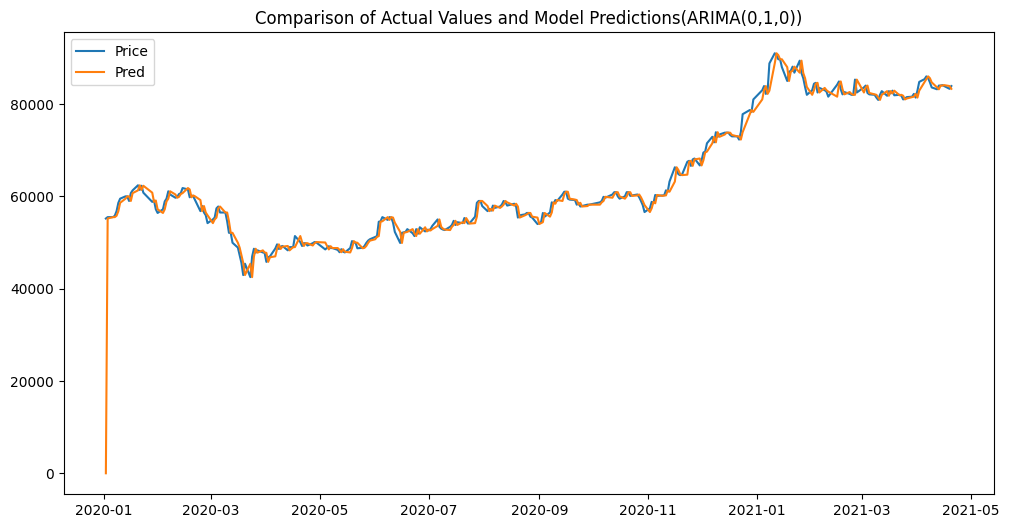

In [18]:
plt.figure(figsize=(12,6))
plt.plot(samsung_df.index, samsung_df.price, label='Price')
plt.plot(pred, label='Pred')
plt.title('Comparison of Actual Values and Model Predictions(ARIMA(0,1,0))')
plt.legend()
plt.show()

예측값과 실제값이 유사하게 나타남을 확인

### 모델 진단

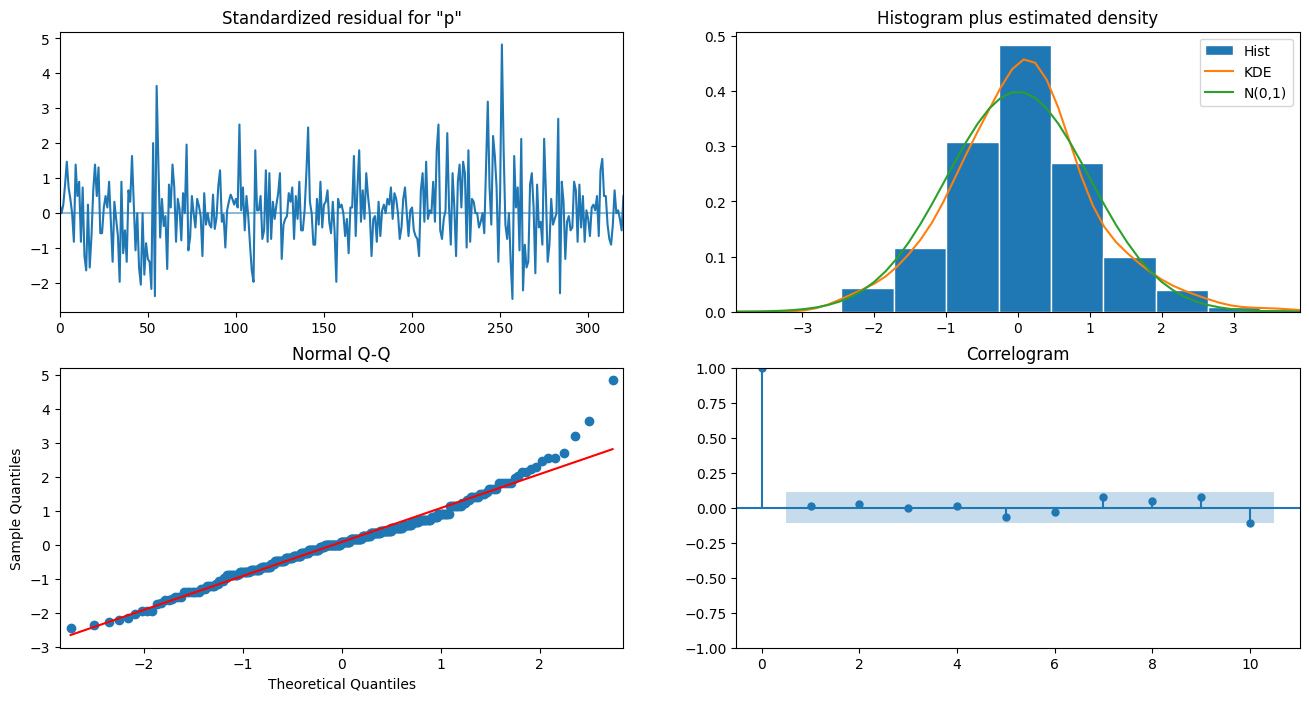

In [20]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()